In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
import io
import matplotlib.ticker as ticker
print('keras version:{}'.format(keras.__version__))

keras version:2.4.3


In [3]:
#upload input file
from google.colab import files
uploaded=files.upload()

Saving TSLA.csv to TSLA.csv


In [4]:
df=pd.read_csv(io.StringIO(uploaded['TSLA.csv'].decode('utf-8')),sep=',')
print('data frame dimension:', df.shape)
df.head()

data frame dimension: (1328, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


In [5]:
def prepare_data(df, n_training_size, timestep, period):

  #split dataset to training set and testing set: 80% for training and 20% for testing
  training_set = df.iloc[:np.int(len(df)*0.8), 1:2].values
  testing_set = df.iloc[np.int(len(df)*0.8):, 1:2].values
 
  # Feature Scaling
  sc = MinMaxScaler(feature_range = (0, 1)) # price cannot be negative, so scale it to (0, 1)
  training_set_scaled = sc.fit_transform(training_set)
  testing_set_scaled = sc.fit_transform(testing_set)

  print('training set dim:{}'.format(training_set_scaled.shape))
  print('testing set dim:{}'.format(testing_set_scaled.shape))

  # Creating a data structure with 60 time-steps and 1 output
  X_train = []
  y_train = []
  for i in range(timestep, n_training_size-period):
      X_train.append(training_set_scaled[i-timestep:i, 0])
      y_train.append(training_set_scaled[i+period, 0]) #1 day lag
      
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  #(740, 60, 1)
  return training_set, testing_set, training_set_scaled, testing_set_scaled, X_train, y_train



In [6]:
n_training_size, timestep =(np.int(len(df)*0.8), 60)
period=7-1 #lag days-1
training_set, testing_set, training_set_scaled, testing_set_scaled, X_train, y_train = prepare_data(df, n_training_size, timestep, period)

training set dim:(1062, 1)
testing set dim:(266, 1)


In [81]:
def build_model(units=32, Dropout_rate=0.2, batch_size=32, epochs=32):
  model = Sequential()
  #Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units=units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  model.add(Dropout(Dropout_rate))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units=units, return_sequences = True))
  model.add(Dropout(Dropout_rate))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units=units, return_sequences = True))
  model.add(Dropout(Dropout_rate))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units=units))
  model.add(Dropout(Dropout_rate))
  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
  return model

In [82]:
units, Dropout_rate, batchsize, epochs = (50, 0.2, 32, 32)
print('epochs:{}'.format(epochs))
model = build_model(units, Dropout_rate, batchsize, epochs)

epochs:32
Epoch 1/32
33/33 [==============================] - 2s 51ms/step - loss: 0.0476
Epoch 2/32
33/33 [==============================] - 2s 53ms/step - loss: 0.0171
Epoch 3/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0169
Epoch 4/32
33/33 [==============================] - 2s 53ms/step - loss: 0.0171
Epoch 5/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0168
Epoch 6/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0169
Epoch 7/32
33/33 [==============================] - 2s 53ms/step - loss: 0.0149
Epoch 8/32
33/33 [==============================] - 2s 53ms/step - loss: 0.0155
Epoch 9/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0154
Epoch 10/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0157
Epoch 11/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0148
Epoch 12/32
33/33 [==============================] - 2s 52ms/step - loss: 0.0153
Epoch 13/32
33/33 [========

In [83]:
def prediction(model, df, timestep, period):
  # Getting the predicted stock price of 2017
  dataset_train = df.iloc[:n_training_size-period, 1:2]
  dataset_test = df.iloc[n_training_size-period:, 1:2]
  dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - timestep:].values
  inputs = inputs.reshape(-1,1)
  print("inputs.shape", inputs.shape)
  sc = MinMaxScaler(feature_range = (0, 1)) # price cannot be negative, so scale it to (0, 1)f
  inputs = sc.fit_transform(inputs)
  X_test = []
  Y_test = []
  print("end", np.int(len(df))-np.int(len(df)*0.8)+timestep-period)
  for i in range(timestep, np.int(len(df))-np.int(len(df)*0.8)+timestep-period):
      X_test.append(inputs[i-timestep:i, 0])
      Y_test.append(inputs[i, 0])
  X_test = np.array(X_test)
  Y_test = np.array(Y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  print(X_test.shape)
  print(Y_test.shape)
  # (459, 60, 1)

  #Make Predictions using the test set
  predicted_stock_price = model.predict(X_test)
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)
  print("predicted_stock_price.shape:{}".format(predicted_stock_price.shape))
  return predicted_stock_price


In [84]:
predicted_stock_price= prediction(model, df, timestep, period)

inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


In [85]:
def plot_figure(model_name, df,dataset_test, predicted_stock_price, period):
  # Getting the predicted stock price of 2017
  dataset_train = df.iloc[:n_training_size-period, 1:2]
  dataset_test = df.iloc[n_training_size-period:, 1:2]
  # Visualising the results
  plt.figure(figsize=(8,8))
  plt.locator_params(nbins=10)
  plt.plot(df.loc[n_training_size-period:, "Date"],dataset_test.values, color = "blue" , label = "Real Stock Price")
  plt.plot(df.loc[n_training_size+period:, "Date"],predicted_stock_price, color = "red", label = "{}".format(model_name))
  # plt.xticks(np.arange(0,459,60))
  
  ax = plt.gca()
  ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
  # for ind, label in enumerate(ax.xaxis.get_ticklabels()):
  #   if ind % 30 == 0:  # every 10th label is kept
  #       label.set_visible(True)
  #   else:
  #       label.set_visible(False)
  plt.title("TESLA Stock Price Prediction")
  plt.xticks(rotation=45)
  plt.xlabel("Date")
  plt.ylabel("Stock Price")
  plt.legend(loc=2)
  plt.show()


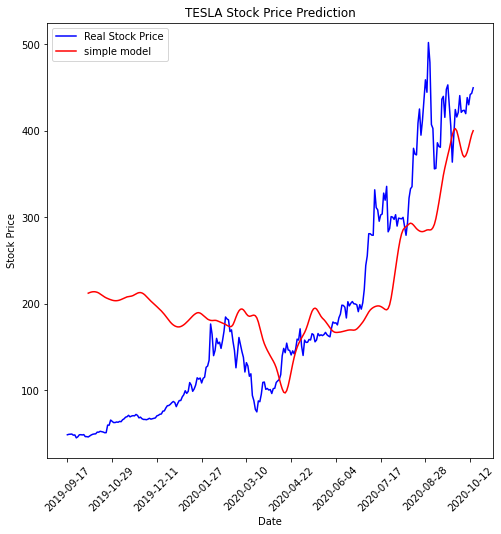

In [86]:
dataset_test = df.iloc[n_training_size-period:, 1:2]
plot_figure('simple model',df,dataset_test, predicted_stock_price, period)

In [87]:
units_settings = [25, 50, 100]
Dropout_rate_settings = [0.1, 0.2]
batchsize_settings=[32, 64, 128]
period_settings = [7, 21]
tiemstep_settings = [30]
period_settings=[7]
models_dict ={}
performance_dict={}
for units in units_settings:
  for batch_size in batchsize_settings:
    for timestep in tiemstep_settings:
      for period in period_settings:
        models_dict.update({'units:{0}|batchsize{1}|timestep:{2}|period:{3}'.format(units,batch_size, timestep, period): (units, batch_size, timestep, period)})
print(models_dict)    

{'units:25|batchsize32|timestep:30|period:7': (25, 32, 30, 7), 'units:25|batchsize64|timestep:30|period:7': (25, 64, 30, 7), 'units:25|batchsize128|timestep:30|period:7': (25, 128, 30, 7), 'units:50|batchsize32|timestep:30|period:7': (50, 32, 30, 7), 'units:50|batchsize64|timestep:30|period:7': (50, 64, 30, 7), 'units:50|batchsize128|timestep:30|period:7': (50, 128, 30, 7), 'units:100|batchsize32|timestep:30|period:7': (100, 32, 30, 7), 'units:100|batchsize64|timestep:30|period:7': (100, 64, 30, 7), 'units:100|batchsize128|timestep:30|period:7': (100, 128, 30, 7)}


training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0950
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0234
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0203
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0193
Epoch 5/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0187
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0183
Epoch 7/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0191
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0177
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0181
Epoch 10/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0166
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


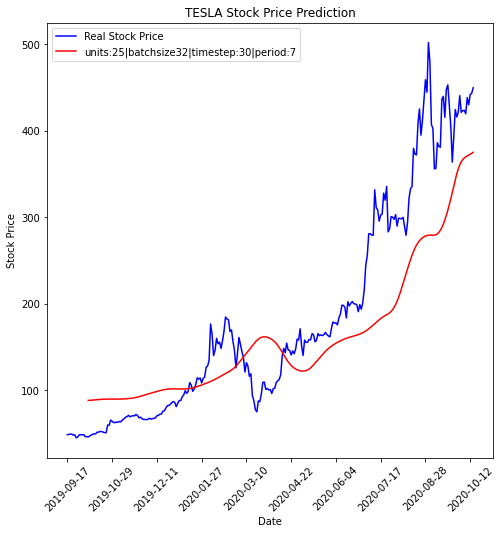

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
17/17 [==============================] - 1s 42ms/step - loss: 0.1284
Epoch 2/10
17/17 [==============================] - 1s 44ms/step - loss: 0.0313
Epoch 3/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0244
Epoch 4/10
17/17 [==============================] - 1s 42ms/step - loss: 0.0224
Epoch 5/10
17/17 [==============================] - 1s 44ms/step - loss: 0.0210
Epoch 6/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0207
Epoch 7/10
17/17 [==============================] - 1s 42ms/step - loss: 0.0190
Epoch 8/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0204
Epoch 9/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0183
Epoch 10/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0267
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


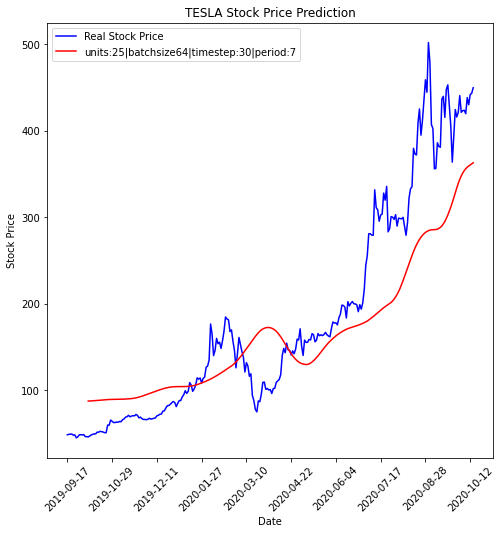

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
9/9 [==============================] - 0s 51ms/step - loss: 0.1886
Epoch 2/10
9/9 [==============================] - 0s 55ms/step - loss: 0.0571
Epoch 3/10
9/9 [==============================] - 0s 55ms/step - loss: 0.0326
Epoch 4/10
9/9 [==============================] - 1s 57ms/step - loss: 0.0279
Epoch 5/10
9/9 [==============================] - 1s 56ms/step - loss: 0.0272
Epoch 6/10
9/9 [==============================] - 1s 57ms/step - loss: 0.0261
Epoch 7/10
9/9 [==============================] - 0s 54ms/step - loss: 0.0232
Epoch 8/10
9/9 [==============================] - 1s 56ms/step - loss: 0.0220
Epoch 9/10
9/9 [==============================] - 0s 55ms/step - loss: 0.0197
Epoch 10/10
9/9 [==============================] - 0s 55ms/step - loss: 0.0201
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


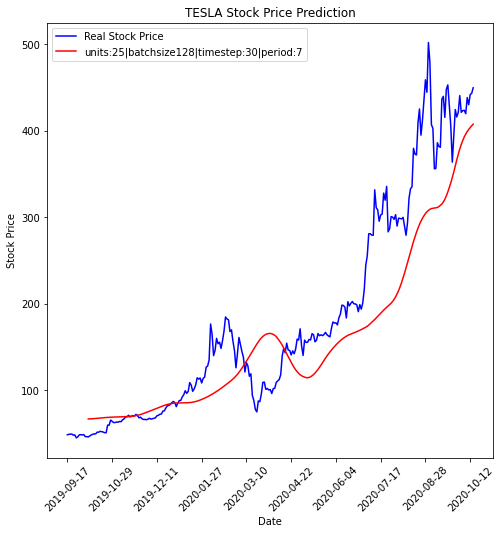

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
33/33 [==============================] - 2s 50ms/step - loss: 0.0649
Epoch 2/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0202
Epoch 3/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0201
Epoch 4/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0178
Epoch 5/10
33/33 [==============================] - 2s 52ms/step - loss: 0.0193
Epoch 6/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0189
Epoch 7/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0165
Epoch 8/10
33/33 [==============================] - 2s 52ms/step - loss: 0.0160
Epoch 9/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0173
Epoch 10/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0151
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


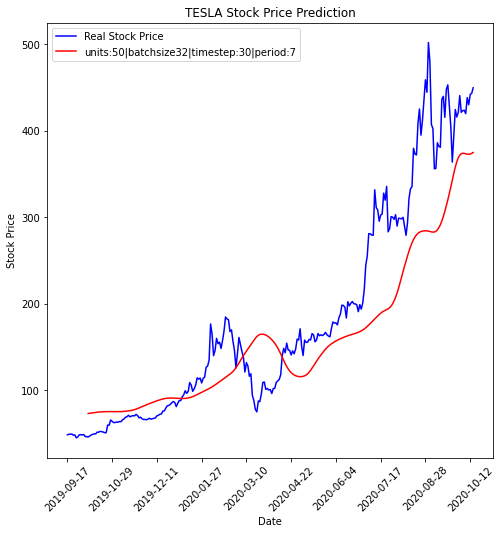

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
17/17 [==============================] - 1s 63ms/step - loss: 0.0878
Epoch 2/10
17/17 [==============================] - 1s 67ms/step - loss: 0.0216
Epoch 3/10
17/17 [==============================] - 1s 66ms/step - loss: 0.0182
Epoch 4/10
17/17 [==============================] - 1s 68ms/step - loss: 0.0170
Epoch 5/10
17/17 [==============================] - 1s 66ms/step - loss: 0.0174
Epoch 6/10
17/17 [==============================] - 1s 65ms/step - loss: 0.0175
Epoch 7/10
17/17 [==============================] - 1s 66ms/step - loss: 0.0168
Epoch 8/10
17/17 [==============================] - 1s 66ms/step - loss: 0.0165
Epoch 9/10
17/17 [==============================] - 1s 68ms/step - loss: 0.0165
Epoch 10/10
17/17 [==============================] - 1s 66ms/step - loss: 0.0150
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


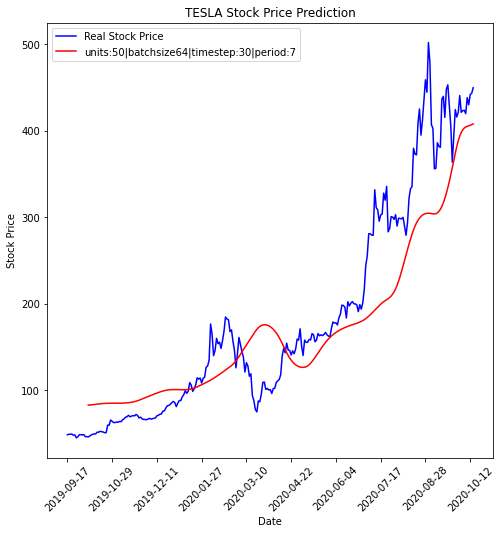

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
9/9 [==============================] - 1s 85ms/step - loss: 0.1358
Epoch 2/10
9/9 [==============================] - 1s 90ms/step - loss: 0.0363
Epoch 3/10
9/9 [==============================] - 1s 90ms/step - loss: 0.0264
Epoch 4/10
9/9 [==============================] - 1s 90ms/step - loss: 0.0218
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 0.0223
Epoch 6/10
9/9 [==============================] - 1s 90ms/step - loss: 0.0212
Epoch 7/10
9/9 [==============================] - 1s 90ms/step - loss: 0.0209
Epoch 8/10
9/9 [==============================] - 1s 88ms/step - loss: 0.0205
Epoch 9/10
9/9 [==============================] - 1s 89ms/step - loss: 0.0258
Epoch 10/10
9/9 [==============================] - 1s 91ms/step - loss: 0.0209
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


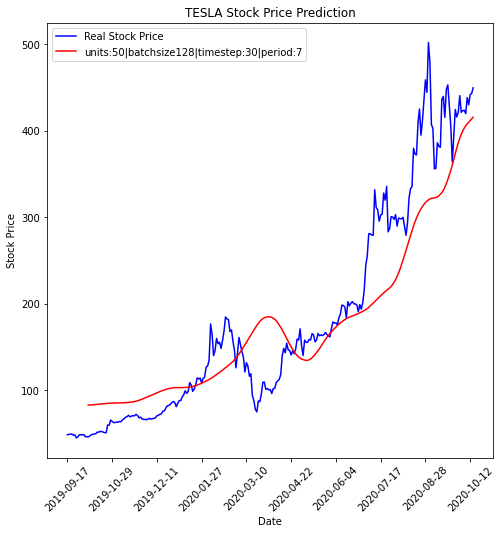

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
33/33 [==============================] - 3s 91ms/step - loss: 0.0399
Epoch 2/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0173
Epoch 3/10
33/33 [==============================] - 3s 96ms/step - loss: 0.0152
Epoch 4/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0148
Epoch 5/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0143
Epoch 6/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0138
Epoch 7/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0202
Epoch 8/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0151
Epoch 9/10
33/33 [==============================] - 3s 95ms/step - loss: 0.0131
Epoch 10/10
33/33 [==============================] - 3s 96ms/step - loss: 0.0133
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


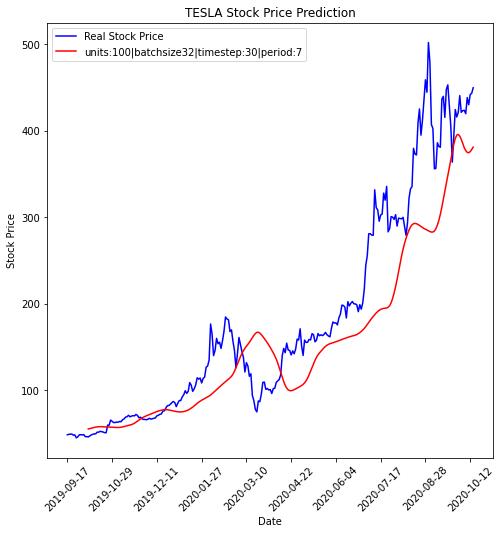

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
17/17 [==============================] - 2s 128ms/step - loss: 0.0692
Epoch 2/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0254
Epoch 3/10
17/17 [==============================] - 2s 133ms/step - loss: 0.0187
Epoch 4/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0154
Epoch 5/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0152
Epoch 6/10
17/17 [==============================] - 2s 133ms/step - loss: 0.0178
Epoch 7/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0148
Epoch 8/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0149
Epoch 9/10
17/17 [==============================] - 2s 133ms/step - loss: 0.0157
Epoch 10/10
17/17 [==============================] - 2s 134ms/step - loss: 0.0157
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


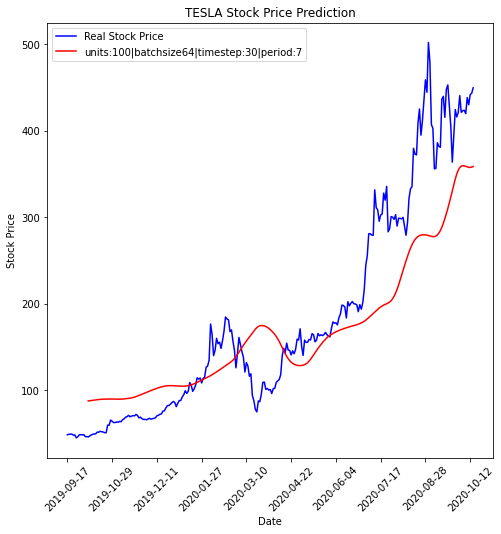

training set dim:(1062, 1)
testing set dim:(266, 1)
Epoch 1/10
9/9 [==============================] - 2s 221ms/step - loss: 0.1190
Epoch 2/10
9/9 [==============================] - 2s 219ms/step - loss: 0.0367
Epoch 3/10
9/9 [==============================] - 2s 217ms/step - loss: 0.0225
Epoch 4/10
9/9 [==============================] - 2s 218ms/step - loss: 0.0196
Epoch 5/10
9/9 [==============================] - 2s 220ms/step - loss: 0.0201
Epoch 6/10
9/9 [==============================] - 2s 220ms/step - loss: 0.0230
Epoch 7/10
9/9 [==============================] - 2s 218ms/step - loss: 0.0162
Epoch 8/10
9/9 [==============================] - 2s 218ms/step - loss: 0.0166
Epoch 9/10
9/9 [==============================] - 2s 221ms/step - loss: 0.0154
Epoch 10/10
9/9 [==============================] - 2s 221ms/step - loss: 0.0264
inputs.shape (303, 1)
end 289
(259, 30, 1)
(259,)
predicted_stock_price.shape:(259, 1)


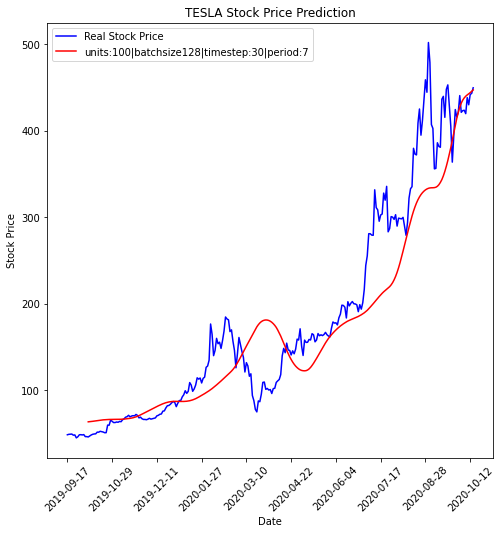

In [88]:
performance_dict ={}
for model_name, model_settings in models_dict.items():
  units, batch_size, timestep, period = model_settings
  temp_performance ={}
  training_set, testing_set, training_set_scaled, testing_set_scaled, X_train, y_train=prepare_data(df, n_training_size, timestep, period)
  Dropout_rate=0.2
  epochs=10
  model =build_model(units, Dropout_rate, batch_size, epochs)
  predicted_stock_price= prediction(model, df, timestep, period)
  performance_dict.update({'{}'.format(model_name):predicted_stock_price})
  dataset_test = df.iloc[n_training_size-period:, 1:2]
  plot_figure(model_name,df,dataset_test, predicted_stock_price, period) 

In [89]:
new_performance_dict={}
for model_name, single_perf_list in performance_dict.items():
  single_perf_list = single_perf_list.tolist()
  # print(perf_list)
  new_perf_list = [ele for first_list in single_perf_list for ele in first_list]
  print(new_perf_list)
  print(len(new_perf_list))
  new_performance_dict.update({'{}'.format(model_name):new_perf_list})


[88.2086181640625, 88.32328796386719, 88.4583740234375, 88.61127471923828, 88.7724609375, 88.93724822998047, 89.10044860839844, 89.25076293945312, 89.37739562988281, 89.48345947265625, 89.5695571899414, 89.63611602783203, 89.68974304199219, 89.73359680175781, 89.76384735107422, 89.77974700927734, 89.7831802368164, 89.77556610107422, 89.76512908935547, 89.75640869140625, 89.7540512084961, 89.7703628540039, 89.80765533447266, 89.87247467041016, 89.96266174316406, 90.07649993896484, 90.20846557617188, 90.34934997558594, 90.50687408447266, 90.69654846191406, 90.9371337890625, 91.24168395996094, 91.60920715332031, 92.03321838378906, 92.50267791748047, 93.0054931640625, 93.52536010742188, 94.05513000488281, 94.5787124633789, 95.09149932861328, 95.5987319946289, 96.10343170166016, 96.6082534790039, 97.11619567871094, 97.6200942993164, 98.11714172363281, 98.60025024414062, 99.06816101074219, 99.51818084716797, 99.94178771972656, 100.3309326171875, 100.67326354980469, 100.96405029296875, 101.19

In [90]:
len(new_perf_list)

259

In [91]:

index = df.loc[n_training_size+period:, "Date"]
print('index length:', len(index))
df_performance = pd.DataFrame.from_dict(new_performance_dict, orient='columns')
df_performance.index = index

print(len(df_performance))
df_performance.head()

index length: 259
259


,units:25|batchsize32|timestep:30|period:7,units:25|batchsize64|timestep:30|period:7,units:25|batchsize128|timestep:30|period:7,units:50|batchsize32|timestep:30|period:7,units:50|batchsize64|timestep:30|period:7,units:50|batchsize128|timestep:30|period:7,units:100|batchsize32|timestep:30|period:7,units:100|batchsize64|timestep:30|period:7,units:100|batchsize128|timestep:30|period:7
Date,,,,,,,,,
2019-10-07,88.208618,87.456802,66.769936,73.131004,82.745026,82.813042,55.180248,87.602074,63.464214
2019-10-08,88.323288,87.537048,66.827980,73.332993,82.890503,82.907654,55.635677,87.808449,63.627235
2019-10-09,88.458374,87.641357,66.911057,73.562447,83.067101,83.028992,56.102894,88.043411,63.826103
2019-10-10,88.611275,87.775101,67.028786,73.810684,83.269753,83.186646,56.557465,88.297287,64.062462
2019-10-11,88.772461,87.919800,67.158409,74.067451,83.489792,83.352951,56.981216,88.560913,64.313774


259


<Figure size 1152x576 with 0 Axes>

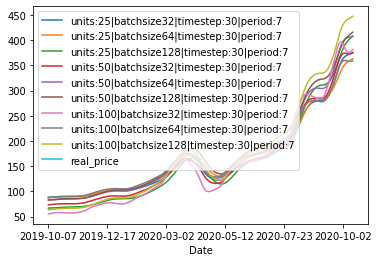

In [92]:
real_price = df.loc[n_training_size+period:, "Open"]
print(len(real_price))
df_performance['real_price']=real_price
plt.figure(figsize=(16,8))
df_performance.plot()

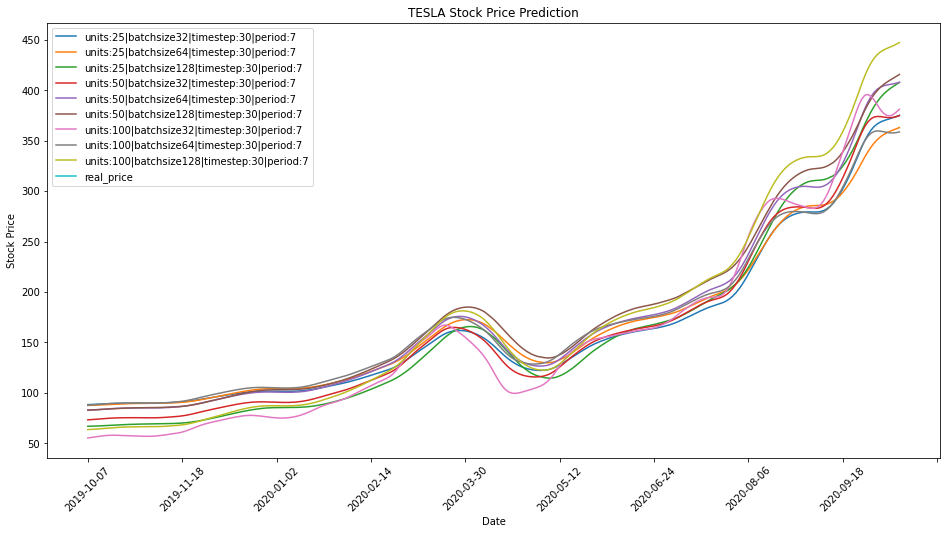

In [93]:
plt.figure(figsize=(16,8))
for column in df_performance:
  plt.plot(df.loc[n_training_size+period:, "Date"], df_performance[column], label =column)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title("TESLA Stock Price Prediction")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend(loc=2)
plt.show()

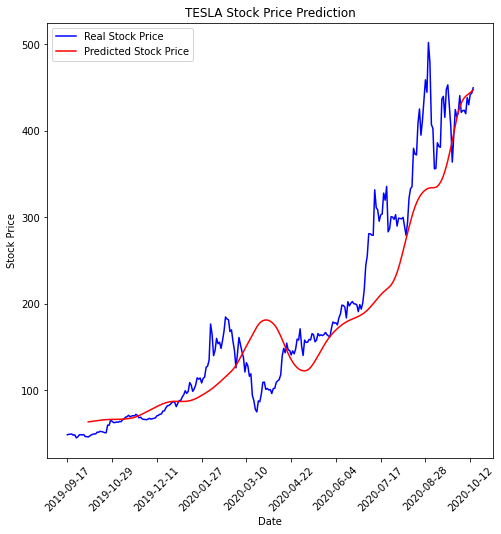

In [94]:
# def plot_all_model_results(performance_dict)
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:n_training_size-period, 1:2]
dataset_test = df.iloc[n_training_size-period:, 1:2]
# Visualising the results
plt.figure(figsize=(8,8))
plt.locator_params(nbins=10)
plt.plot(df.loc[n_training_size-period:, "Date"],dataset_test.values, color = "blue" , label = "Real Stock Price")
plt.plot(df.loc[n_training_size+period:, "Date"],predicted_stock_price, color = "red", label = "Predicted Stock Price")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title("TESLA Stock Price Prediction")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend(loc=2)
plt.show()

make predictions for future two weeks, until Oct 28, 2020

In [95]:
# calculate date difference
from datetime import datetime
cur_day = datetime(2020, 10, 14)
end_day = datetime(2020, 10, 28)
time_horizon = (end_day - cur_day).days

In [96]:
# get the date of following two weeks
dates = df['Date']
last_date = '2020-10-15'
timestamp_list = pd.date_range(last_date, periods = time_horizon).tolist()
datestring_list = [i.strftime("%Y-%m-%d") for i in timestamp_list] 
datestring_list
# delete weekends
index = [2,3,9,10]
to_del = object()
for ind in index:
    datestring_list[ind] = to_del
for i in index:
    datestring_list.remove(to_del)
datestring_list

['2020-10-15',
 '2020-10-16',
 '2020-10-19',
 '2020-10-20',
 '2020-10-21',
 '2020-10-22',
 '2020-10-23',
 '2020-10-26',
 '2020-10-27',
 '2020-10-28']

In [97]:
timestep

30

In [98]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:n_training_size, 1:2]
dataset_test = df.iloc[n_training_size:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timestep:].values
inputs = inputs.reshape(-1,1)
sc = MinMaxScaler(feature_range = (0, 1)) # price cannot be negative, so scale it to (0, 1)
inputs = sc.fit_transform(inputs)
X_test = []
#get the test data
for i in range(timestep, np.int(len(df))-np.int(len(df)*0.8)+timestep-period):
  X_test.append(inputs[i-timestep:i, 0])
print(len(X_test))
# # X_test.shape[0] has 478 values, we want use the last 10 value to predict 
del X_test[0:len(X_test)-10]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

259
(10, 30, 1)


<h1>We trained a series of models, and selecting a different model may result in a different performance and hence a distinct visualization.<h1>

In [99]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

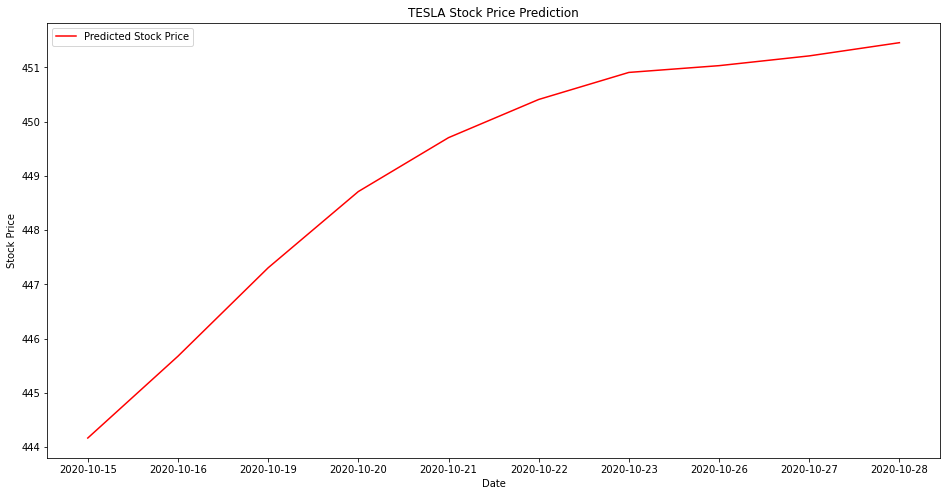

In [100]:
# Visualising the results
plt.figure(figsize=(16,8))
plt.plot(datestring_list,predicted_stock_price, color = 'red', label = 'Predicted Stock Price')
plt.xticks(np.arange(0,10))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
figure = plt.gcf()
plt.show()